# NLP: Yelp Review to Rating
### Authors: Tanvee Desai and Tanner Arrizabalaga

Hello! In this project, we will be looking over Yelp reviews (data available here: https://www.yelp.com/dataset) and utilizing ML/DL to accurately predict what the reviews star rating is based solely on text.

This project is split into the following parts
- Libraries
- EDA
- Data Cleaning
    - Stop word removal, HTML parsing, punctuation removal, etc.
    - Creation of a cleaned *and* stemmed dataset
- Model Implementation
    - Simple BOW Model Neural Network
    - LSTM
    - One vs. All LSTM Approach
- Exploring Challenges
    - Challenge 5
    - Challenge 6

### Importing necessary libraries

In [5]:
# General Libraries
import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
import nltk
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer


# ML/DL
import tensorflow as tf
import pickle

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, BatchNormalization, SpatialDropout1D, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import utils
from keras import regularizers

In [54]:
yelp = pd.read_json("./yelp_review_training_dataset.jsonl", lines = True)
yelp.head()

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


How large is the data?

In [55]:
yelp.shape

(533581, 3)

### EDA - Stars
Not too much to go off of, but let's get a general understanding of our data. How many nulls do we have?

In [56]:
yelp.isna().sum()

review_id    0
text         0
stars        0
dtype: int64

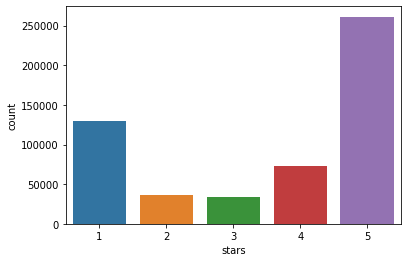

In [57]:
sns.countplot(yelp['stars'])

One thing we can potentially look at is whether or not the reviews are balanced. Let's say >=4 is positive, and <4 is negative. If we do see a significant difference in positive and negative reviews, we can balance it before training.

Positive to negative review ratio:  1.6679183395916979


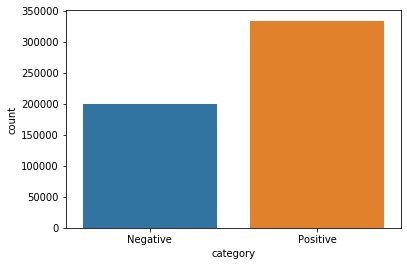

In [58]:
def pos_or_neg(x):
    if x >= 4:
        return "Positive"
    else:
        return "Negative"
    
yelp['category'] = yelp['stars'].apply(pos_or_neg)

sns.countplot(yelp['category'])
num_pos = np.count_nonzero(yelp['category'] == 'Positive')
num_neg = np.count_nonzero(yelp['category'] == 'Negative')
print("Positive to negative review ratio: ", num_pos / num_neg)

There are roughly 1 and 2/3 times as many positive reviews as negative reviews. We will first try no class balancing when building the model, but may turn to class balancing later on.

### Data Cleaning - Text

In [62]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
print(STOPWORDS)

def adjust_stopwords(stopwords):
    words_to_keep = set('nor', 'not', 'very', 'no')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    new_text = BeautifulSoup(text, "lxml").text # HTML decoding
    new_text = new_text.lower() # lowercase text
    new_text = REPLACE_BY_SPACE_RE.sub(' ', new_text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    new_text = BAD_SYMBOLS_RE.sub(' ', new_text) # delete symbols which are in BAD_SYMBOLS_RE from text
   
    ps = PorterStemmer()
    
    new_text = ' '.join(ps.stem(word) for word in new_text.split()) # keeping all words, no stop word removal
#     new_text = ' '.join(ps.stem(word) for word in new_text.split() if word not in STOPWORDS) # delete stopwords from text and stem
    return new_text


{'nor', 'against', 'm', 'not', "mightn't", 'am', 'them', 'very', 'my', 'ain', 'shouldn', 'mightn', 'be', 'having', 'this', 'those', 'down', 'that', 'i', 'does', 'about', 're', "needn't", 'any', 'can', 'and', 'why', 'being', 'some', 'we', 'what', 'aren', 'didn', 'most', 'have', 'haven', 'himself', 'ma', 'after', 'is', 'do', 'by', 'up', 'just', 'each', 'shan', 'don', 'doesn', 'out', "she's", 'below', 'on', 'where', 'its', 'wouldn', 'did', 'then', 'yours', 'won', 'of', 'at', 'been', 'herself', 'they', 'over', 'in', 'who', "it's", "haven't", 'which', 'you', 'until', 'under', "doesn't", "won't", 'now', 'but', 'all', 'than', "you're", 'he', 'above', 'will', 'to', 'couldn', "hadn't", 'our', "you've", 'whom', 'before', 'few', 't', 'ourselves', "shouldn't", 'or', 'so', 'd', 'it', 'myself', 'the', 'his', 'hasn', 'more', 'during', "you'll", "wasn't", 'wasn', 'same', 'a', 'doing', 'her', "shan't", 'weren', 'yourself', 'should', 'was', "wouldn't", 'too', 'ours', 'has', 'while', 'for', 'had', 'itsel

C:\Users\Tanner\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Tanner\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Tanner\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.marketwired.com/press-release/lease-of-spot-concord-place-cafe-terminated-tsx-venture-spp-1950108.htm

Unfortunate!" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get 

In [ ]:
yelp['text'] = yelp['text'].apply(clean_text)
yelp.to_csv('cleaned_yelp_stemmed.csv')

In [63]:
text_1 = "\"Good morning, cocktails for you?\" \nWait...what? Oh...it's Vegas!\n\nDining here, you best not be dieting because this place is literally the definition of excess, but in a good way. I'm a sucker for benedicts so that was awesome. \nService was really great too and the staff was so welcoming. It was our first stop just after landing so really appreciate the service.\n\nBack in Hawaii this reminds me of Zippys or Anna Millers - that home feeling. Prices are a bit high, but for what you get it's totally worth it. Will remember this place if I ever return to Vegas in the future."
text_2 = "80 bucks, thirty minutes to fix my shattered iPhone screen. Verizon won't help you so go here"
text_3 = "Tr\u00e8s grand caf\u00e9, mais aussi calme et reposant, je m'y suis arr\u00eat\u00e9 alors que j'\u00e9tais dans le coin.\n\nOn peu y mang\u00e9 le midi, prendre une p\u00e2tisserie ou un caf\u00e9/th\u00e9. \n\nJ'ai prit un th\u00e9 qui \u00e9tait vraiment bon, et je me suis pos\u00e9 devant une des grandes baies vitr\u00e9es sur un coussin et j'ai relax\u00e9 compl\u00e8tement pendant 2 heures. \n\nMais c'est aussi une coop\u00e9rative d'artiste, avec une estrade etc.\n\nIl y a aussi un magasin Bio \u00e0 l'entr\u00e9e o\u00f9 vous retrouverez des savons, huile d'olive et plein d'autres produits."
text_4 = "Sadly, as of July 28, 2016, Silverstein bakery is permanently closed. I went there today in person and found the bad news posted on their door. :("
text_5 = "I went here  they were about to close but the cashier was especially helpful ..but I guess they were tired of work..."

clean_text(text_1)

'good morn cocktail for you wait what oh it s vega dine here you best not be diet becaus thi place is liter the definit of excess but in a good way i m a sucker for benedict so that wa awesom servic wa realli great too and the staff wa so welcom it wa our first stop just after land so realli appreci the servic back in hawaii thi remind me of zippi or anna miller that home feel price are a bit high but for what you get it s total worth it will rememb thi place if i ever return to vega in the futur'

# Model Implementation

### Evaluation
#### 1. Average Star Error (Average Absolute offset between predicted and true number of stars)
#### 2. Accuracy (Exact Match -- Number of exactly predicted star ratings / total samples)

In [2]:
def MAE(y_true, y_pred):
    diffs = np.abs(y_true - y_pred)
    loss = np.mean(diffs)
    return loss

def Accuracy(y_true, y_pred):
    correct = y_true == y_pred
    cor_count = np.count_nonzero(correct)
    return cor_count / len(y_true)

### Train/Test Split (Unbalanced and balanced)

In [3]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')
yelp.head()

,Unnamed: 0,review_id,text,stars,category
0,0,Q1sbwvVQXV2734tPgoKj4Q,total bill for thi horribl servic over 8g thes...,1,Negative
1,1,GJXCdrto3ASJOqKeVWPi6Q,i ador travi at the hard rock s new kelli card...,5,Positive
2,2,2TzJjDVDEuAW6MR5Vuc1ug,i have to say that thi offic realli ha it toge...,5,Positive
3,3,yi0R0Ugj_xUx_Nek0-_Qig,went in for a lunch steak sandwich wa delici a...,5,Positive
4,4,11a8sVPMUFtaC7_ABRkmtw,today wa my second out of three session i had ...,1,Negative


In [66]:
X = yelp['text'].fillna('').values
y = yelp['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Baseline Sequential Model

In [69]:
max_words = 3000
tokenizer = text.Tokenizer(num_words=max_words, char_level=False)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (373506, 3000)
X_test shape: (160075, 3000)
y_train shape: (373506, 5)
y_test shape: (160075, 5)


Let's save the tokenizer as well for our test submission file script.

In [70]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Here, we are computing a single model, but in future we will optimize on several parameters, listed below
* Batch size
* Learning rate
* Gradient clipping
* Drop out
* Batch normalization
* Optimizers
* Regularization

After some tests, the main variations I noticed were from the learning rate, regularization, and the choice of the optimizer. With that being said, this baseline model will use **ADAM with a learning rate of .0001 and regularization (kernel, bias, and activity)**

In [74]:
batch_size = 512
epochs = 10

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.0001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.95, amsgrad=False)

model = Sequential()
model.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/10
298804/298804 [==============================] - 38s 128us/step - loss: 1.2997 - accuracy: 0.6899 - val_loss: 1.0994 - val_accuracy: 0.7449
Epoch 2/10
298804/298804 [==============================] - 16s 53us/step - loss: 1.0668 - accuracy: 0.7480 - val_loss: 1.0303 - val_accuracy: 0.7500
Epoch 3/10
298804/298804 [==============================] - 11s 37us/step - loss: 0.9758 - accuracy: 0.7628 - val_loss: 0.9810 - val_accuracy: 0.7524
Epoch 4/10
298804/298804 [==============================] - 11s 37us/step - loss: 0.9052 - accuracy: 0.7747 - val_loss: 0.9418 - val_accuracy: 0.7528
Epoch 5/10
298804/298804 [==============================] - 11s 38us/step - loss: 0.8479 - accuracy: 0.7826 - val_loss: 0.9077 - val_accuracy: 0.7523
Epoch 6/10
298804/298804 [==============================] - 11s 37us/step - loss: 0.8001 - accuracy: 0.7910 - val_loss: 0.8838 - val_accuracy: 0.7531
Epoch 7/10
298804/298804 [======================

In [75]:
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

160075/160075 [==============================] - 13s 84us/step
Test accuracy: 0.7534281015396118


In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

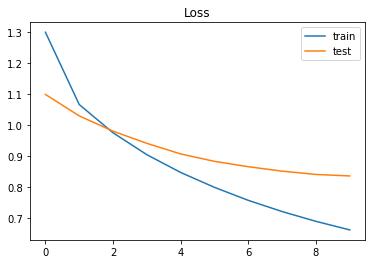

In [76]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

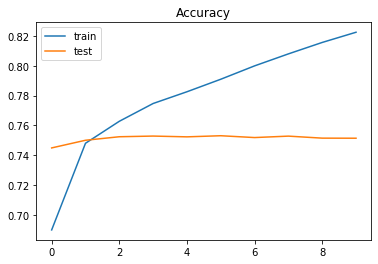

In [77]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [85]:
model.save('./models/baseline.h5')

### Now training with several parameter changes

In [ ]:
import itertools

batch_sizes = [128, 256, 512]
epochs = [5]
learning_rates = [.01, .001, .0001]
dropout = [False, True]
batch_norm = [False, True]
regularization = [True]
optimizers = ["SGD", "RMSProp", "ADAM"]

all_lists = [batch_sizes, epochs, learning_rates, dropout, batch_norm, regularization, optimizers]

params_to_test = list(itertools.product(*all_lists))
print(len(params_to_test))

In [ ]:
models = {}
histories = {}
scores = {}

for params in params_to_test:
    print(params)
    batch_size, epochs, learning_rate, dropout, batch_norm, regularization, opt = params
    
    if opt == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False)
    elif opt == "RMSProp":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9)
    elif opt == "ADAM":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.99, amsgrad=False)
    else:
        optimizer = keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95)
    
    model = Sequential()
    model.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    
    # Check Batch Normalization
    if batch_norm:
        model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    
    # Check Dropout
    if dropout:
        model.add(Dropout(0.2))
    
    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_split=0.1)
    
    models[params] = model
    histories[params] = history
    
    score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print(score)
    
    scores[params] = score

### LSTM Model


#### Specific Data Prep

In [78]:
from sklearn.model_selection import train_test_split

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

max_words = 3000
maxlen = 400

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# For the LSTM, we are going to pad our sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

(373506,) (373506, 5)
(160075,) (160075, 5)


#### LSTM #1

In [79]:
batch_size = 512
epochs = 10

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

lstm = Sequential()
lstm.add(Embedding(max_words, 128, input_length=maxlen))
lstm.add(SpatialDropout1D(0.2))
lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4)))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(BatchNormalization())
lstm.add(Dense(5, activation='sigmoid'))

lstm.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = lstm.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/10
298804/298804 [==============================] - 87s 290us/step - loss: 0.7840 - accuracy: 0.7080 - val_loss: 0.6677 - val_accuracy: 0.7473
Epoch 2/10
298804/298804 [==============================] - 82s 275us/step - loss: 0.6482 - accuracy: 0.7529 - val_loss: 0.6177 - val_accuracy: 0.7638
Epoch 3/10
298804/298804 [==============================] - 82s 273us/step - loss: 0.6089 - accuracy: 0.7650 - val_loss: 0.5955 - val_accuracy: 0.7715
Epoch 4/10
298804/298804 [==============================] - 84s 280us/step - loss: 0.5862 - accuracy: 0.7724 - val_loss: 0.5892 - val_accuracy: 0.7726
Epoch 5/10
298804/298804 [==============================] - 83s 279us/step - loss: 0.5722 - accuracy: 0.7775 - val_loss: 0.5826 - val_accuracy: 0.7754
Epoch 6/10
298804/298804 [==============================] - 86s 288us/step - loss: 0.5575 - accuracy: 0.7835 - val_loss: 0.5828 - val_accuracy: 0.7750
Epoch 7/10
298804/298804 [=================

#### LSTM #1: Evaluation

In [80]:
score = lstm.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

160075/160075 [==============================] - 11s 68us/step
Test accuracy: 0.7814836502075195


In [81]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 128)          384000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

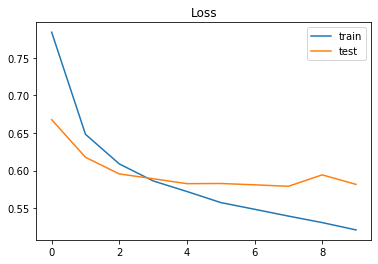

In [82]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

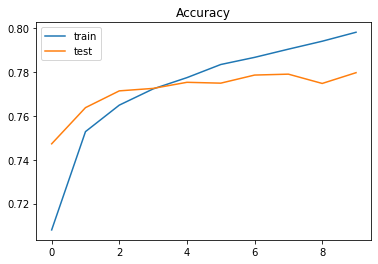

In [83]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Let's save this model as well.

In [84]:
lstm.save('./models/lstm.h5')

C:\Users\Tanner\Anaconda3\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### One vs. All Approach
In the one vs. all approach, it goes by the following idea:
- We will have $N$ learners for the multi-class classification problem, where $N$ is the number of classes
- For each learner $L$, we will train $L$ on our training data $X_{Train}$ and $y_{Train}$. However, $y_{Train}$ consists of only one label, making it a binary classification problem instead of multinomial
    - For instance, learner $L_1$ will still use all of $X_{Train}$, but $y_{Train}$ will now be transformed to be a binary vector $v_i$ where $i$ denotes the star rating we are attempting to predict
- Once we have concluded our training, we will then create an ensemble model (bagging) that does the following
    1. $L_1$, $L_2$, ..., $L_5$ all assign $p_i$ to each record in $X_{Test}$, where $p_i$ is the likelihood observation $x_n$ belongs to class $i$
    2. From there, our prediction is the following: $P_n = argmax(p_1, p_2, p_3, p_4, p_5)$
    
After observing the challenge datasets 5 & 6, my partner and I believe this approach is a clever way to tackle the challenges while still having a strong model.

Sources: https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all

In [6]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

max_words = 3000
maxlen = 400

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (373506, 400)
X_test shape: (160075, 400)
y_train shape: (373506, 5)
y_test shape: (160075, 5)


#### Buidling all models

In [8]:
stars = np.arange(1, 6)
models = {}
histories = {}
batch_size = 1024
epochs = 3

for star in stars:
    print(star)
    y_train_sub = y_train[:, star - 1]
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

    sub_lstm = Sequential()
    sub_lstm.add(Embedding(max_words, 128, input_length=maxlen))
    sub_lstm.add(SpatialDropout1D(0.2))
    sub_lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4)))
    sub_lstm.add(MaxPooling1D(pool_size=4))
    sub_lstm.add(LSTM(128))
    sub_lstm.add(BatchNormalization())
    sub_lstm.add(Dense(8))
    sub_lstm.add(Dense(1, activation='sigmoid'))
    
    sub_lstm.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history = sub_lstm.fit(X_train, y_train_sub,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2)
    
    models[star] = sub_lstm
    histories[star] = sub_lstm

1
Train on 298804 samples, validate on 74702 samples
Epoch 1/3
298804/298804 [==============================] - 64s 215us/step - loss: 0.2549 - accuracy: 0.9037 - val_loss: 0.6259 - val_accuracy: 0.7587
Epoch 2/3
298804/298804 [==============================] - 64s 214us/step - loss: 0.1814 - accuracy: 0.9327 - val_loss: 0.2501 - val_accuracy: 0.8884
Epoch 3/3
298804/298804 [==============================] - 63s 212us/step - loss: 0.1574 - accuracy: 0.9423 - val_loss: 0.1903 - val_accuracy: 0.9293
2
Train on 298804 samples, validate on 74702 samples
Epoch 1/3
298804/298804 [==============================] - 65s 216us/step - loss: 0.2556 - accuracy: 0.9206 - val_loss: 0.2745 - val_accuracy: 0.9323
Epoch 2/3
298804/298804 [==============================] - 63s 212us/step - loss: 0.1835 - accuracy: 0.9352 - val_loss: 0.2065 - val_accuracy: 0.9331
Epoch 3/3
298804/298804 [==============================] - 63s 211us/step - loss: 0.1648 - accuracy: 0.9400 - val_loss: 0.2314 - val_accuracy: 0

#### Building an ensemble model (maximization between learners) for all trained models
##### Testing

In [9]:
%%time
# Evaluating the models above (TEST)
y_test_und = pd.DataFrame(y_test)
y_test_true = pd.DataFrame(y_test_und.columns[np.where(y_test_und!=0)[1]]) + 1

# Unload models
lstm_1, lstm_2, lstm_3, lstm_4, lstm_5 = models[1], models[2], models[3], models[4], models[5]

## Predicting the probability for each observation each model
print("Predicting 1 star")
one_star_ps = lstm_1.predict(X_test)
print("Predicting 2 star")
two_star_ps = lstm_2.predict(X_test)
print("Predicting 3 star")
three_star_ps = lstm_3.predict(X_test)
print("Predicting 4 star")
four_star_ps = lstm_4.predict(X_test)
print("Predicting 5 star")
five_star_ps = lstm_5.predict(X_test)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["pred"] = ps.idxmax(axis=1)
ps.head()

print(MAE(ps["pred"], y_test_true[0]))
print(Accuracy(ps["pred"], y_test_true[0]))

Predicting 1 star
Predicting 2 star
Predicting 3 star
Predicting 4 star
Predicting 5 star
0.338453849757926
0.7612744026237701
Wall time: 5min 43s


#### Saving the models


In [10]:
from keras.models import load_model

lstm_1.save("./models/one_star.h5")
lstm_2.save("./models/two_star.h5")
lstm_3.save("./models/three_star.h5")
lstm_4.save("./models/four_star.h5")
lstm_5.save("./models/five_star.h5")

C:\Users\Tanner\Anaconda3\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


# Challenges
### Challenge 5

In [90]:
c5 = pd.read_json("./yelp_challenge_5_with_answers.jsonl", lines = True)
print(c5.shape)
c5.head()

(500, 3)


,review_id,text,stars
0,50,I went to this campus for 1 semester. I was in...,2
1,51,I have rated it a two star based on its compar...,2
2,52,"Just like most of the reviews, we ordered and ...",2
3,53,I only go here if it is an emergency. I HATE i...,2
4,54,Rude staff. I got 60 feeder fish and about 15 ...,2


##### Quick EDA

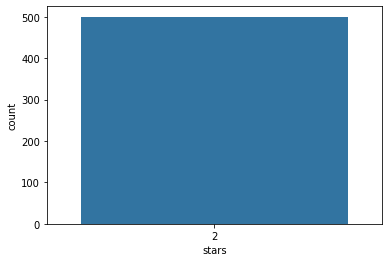

In [91]:
sns.countplot(c5['stars'])

##### Pre-processing

In [92]:
c5['text'] = c5['text'].apply(clean_text)
c5.head()

,review_id,text,stars
0,50,i went to thi campu for 1 semest i wa in busi ...,2
1,51,i have rate it a two star base on it compariso...,2
2,52,just like most of the review we order and paid...,2
3,53,i onli go here if it is an emerg i hate it tha...,2
4,54,rude staff i got 60 feeder fish and about 15 w...,2


##### Load previous tokenizer

In [93]:
X = c5['text'].fillna('').values
y = pd.get_dummies(c5['stars'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

max_words    
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=400)

##### Load and compile models

In [94]:
# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

C:\Users\Tanner\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


##### Evaluate Models

In [95]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 160us/step
[1.984132592201233, 0.2980000078678131]
500/500 [==============================] - 0s 720us/step
[1.4631506433486938, 0.35600000619888306]
[2.29, 0.136]


##### Attempt Ensemble

In [96]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[0.864, 0.33]


##### Misc.

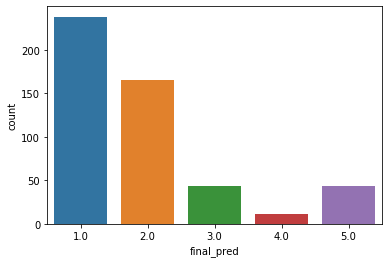

In [97]:
sns.countplot(all_preds["final_pred"])

### Challenge 6

In [98]:
c6 = pd.read_json("./yelp_challenge_6_with_answers.jsonl", lines = True)
print(c6.shape)
c6.head()

(500, 3)


,review_id,text,stars
0,60,Amazing for Trees\n\n$20 for a 5 gallon . I wi...,5
1,61,How the hell can Taco Bell be closed before mi...,5
2,62,I actually had no intention of visiting this p...,5
3,63,Yesterday around 3:30 pm I was driving west on...,5
4,64,DR FITZMAURICE did surgery on both hands on th...,5


##### Quick EDA

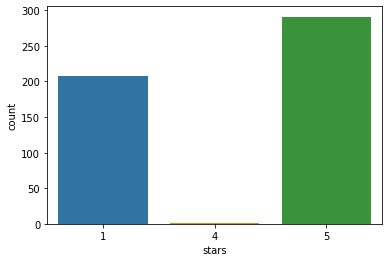

In [99]:
sns.countplot(c6['stars'])

##### Pre-processing

In [100]:
c6['text'] = c6['text'].apply(clean_text)
c6.head()

,review_id,text,stars
0,60,amaz for tree 20 for a 5 gallon i will never g...,5
1,61,how the hell can taco bell be close befor midn...,5
2,62,i actual had no intent of visit thi place at a...,5
3,63,yesterday around 3 30 pm i wa drive west on pi...,5
4,64,dr fitzmauric did surgeri on both hand on the ...,5


##### Load previous tokenizer

In [101]:
X = c6['text'].fillna('').values
y = pd.get_dummies(c6['stars'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

max_words    
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=400)

##### Load and compile models

In [102]:
from keras.models import load_model

# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

##### Evaluate Models

In [103]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 202us/step
[2.3049304752349853, 0.4480000138282776]
500/500 [==============================] - 0s 711us/step
[2.3681153812408446, 0.41600000858306885]
[1.834, 0.45]


##### Attempt Ensemble

In [104]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[2.064, 0.454]


##### Misc.

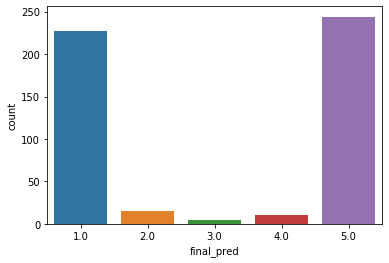

In [105]:
sns.countplot(all_preds["final_pred"])